In [1]:
from deepxde.nn.pytorch.deeponet import DeepONet
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

r = 64
model = DeepONet(
    layer_sizes_branch=[2, 128, 128, r],
    layer_sizes_trunk=[2, 128, 128, r],
    activation="sin",
    kernel_initializer=torch.nn.init.xavier_uniform_,
).to(device)

# initialize weights
def init_fn(module):
    if isinstance(module, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(module.weight)
        module.bias.data.fill_(0.0)

model.apply(init_fn)

optimizer = optim.LBFGS(model.parameters(), line_search_fn="strong_wolfe")

progress_bar = tqdm(range(500))


# 2. data generator that yields batches of (q,p,m,k)
def sample_batch(batch_size, q_range, p_range, m_range, k_range):
    # sample parameters
    m_batch = torch.empty(batch_size,1).uniform_( *m_range )
    k_batch = torch.empty(batch_size,1).uniform_( *k_range )
    # sample points
    q_batch = torch.empty(batch_size,1).uniform_( *q_range )
    p_batch = torch.empty(batch_size,1).uniform_( *p_range )
    # send to device
    for t in (m_batch, k_batch, q_batch, p_batch):
        t.to(device)
    # require gradients for branch inputs
    q_batch.requires_grad_(True)
    p_batch.requires_grad_(True)
    return m_batch, k_batch, q_batch, p_batch

def closure():
    optimizer.zero_grad()

    m_b, k_b, q_b, p_b = sample_batch(
        batch_size=4096,
        q_range=(-4,4),
        p_range=(-4,4),
        m_range=(0.5,4.0),
        k_range=(0.5,4.0),
    )

    # stack branch and trunk inputs
    branch_in = torch.cat((q_b, p_b), dim=1)       # [B,2]
    trunk_in  = torch.cat((m_b, k_b), dim=1)       # [B,2]

    H = model((branch_in, trunk_in))               # [B,1]

    ones = torch.ones_like(H)
    dH_dq, dH_dp = torch.autograd.grad(
        outputs=H,
        inputs=(q_b, p_b),
        grad_outputs=(ones, ones),
        create_graph=True
    )

    # physics losses
    loss_mom   = torch.mean((m_b * dH_dp - p_b)**2)
    loss_force = torch.mean((dH_dq - k_b * q_b)**2)
    
    dqdt = dH_dp
    dpdt = -dH_dq
    dH_dt = dH_dq * dqdt + dH_dp * dpdt
    loss_cons  = torch.mean(dH_dt**2)

    loss = loss_mom + loss_force + loss_cons

    loss.backward()
    return loss

loss_track = []

# training loop
for epoch in progress_bar:
    optimizer.step(closure)
    current = closure().item()
    loss_track.append(current)
    progress_bar.set_postfix(Loss=current)


100%|██████████| 500/500 [00:49<00:00, 10.16it/s, Loss=0.00102] 


In [8]:
torch.save(model.state_dict(), "hnno_mass_spring.pth")

In [3]:
# Generator function for creating uniformly sampled data in the (q, p) space from (q_min, q_max) and (p_min, p_max), convert to meshgrid
def generate_uniform_data(q_min, q_max, p_min, p_max, num_samples):
    q_lin = torch.linspace(q_min, q_max, num_samples)
    p_lin = torch.linspace(p_min, p_max, num_samples)
    P, Q = torch.meshgrid(p_lin, q_lin, indexing='ij')
    P = P.reshape(-1,1).to(device).requires_grad_(True)
    Q = Q.reshape(-1,1).to(device).requires_grad_(True)
    return P, Q

In [4]:
m_test, k_test = 2.0, 1.0
p_test, q_test = generate_uniform_data(-2, 2, -2, 2, 50)
p_test.requires_grad_(True)
q_test.requires_grad_(True)

# pack branch (q,p) and trunk (m,k)
branch = torch.cat((q_test, p_test), dim=1)  # [2500,2]
trunk  = torch.tensor([[m_test, k_test]], device=device).repeat(branch.size(0), 1)

# forward and gradients
H_pred = model((branch, trunk))             # [2500,1]
ones   = torch.ones_like(H_pred)
dH_dq, dH_dp = torch.autograd.grad(
    outputs=H_pred,
    inputs=(q_test, p_test),
    grad_outputs=(ones, ones),
    create_graph=False
)

# compute residuals
loss_mom   = torch.mean((m_test * dH_dp - p_test)**2).item()
loss_force = torch.mean((dH_dq - k_test * q_test)**2).item()
print(f"momentum MSE: {loss_mom:.3e}")
print(f"force    MSE: {loss_force:.3e}")


momentum MSE: 6.309e-05
force    MSE: 1.604e-05


In [5]:
def derivatives_test(state):
    q_val, p_val = state
    # require grad for branch inputs
    q_t = torch.tensor([[q_val]], dtype=torch.float32, requires_grad=True, device=device)
    p_t = torch.tensor([[p_val]], dtype=torch.float32, requires_grad=True, device=device)

    # pack inputs and predict
    inp_branch = torch.cat((q_t, p_t), dim=1)
    inp_trunk  = torch.tensor([[m_test, k_test]], device=device)
    H_t = model((inp_branch, inp_trunk))

    dH_dq_t, dH_dp_t = torch.autograd.grad(
        outputs=H_t,
        inputs=(q_t, p_t),
        grad_outputs=torch.ones_like(H_t),
        create_graph=False
    )

    dqdt = dH_dp_t.item()
    dpdt = -dH_dq_t.item()  # no damping here
    return np.array([dqdt, dpdt])


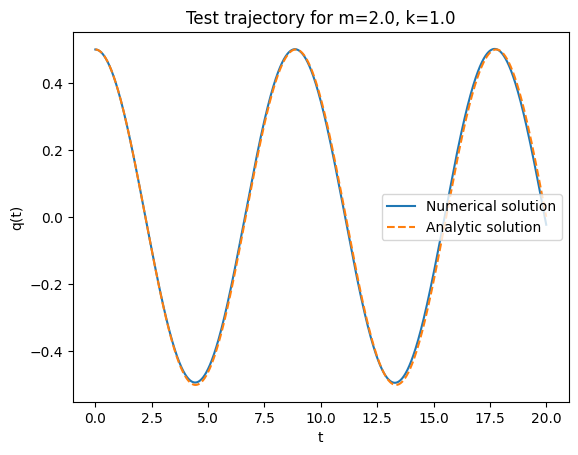

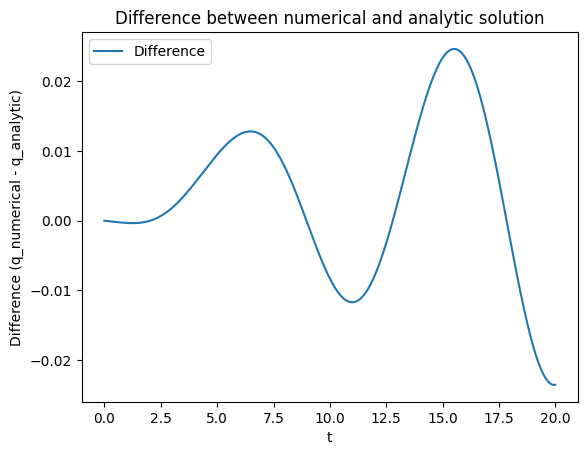

Text(0.5, 1.0, 'Training Loss')

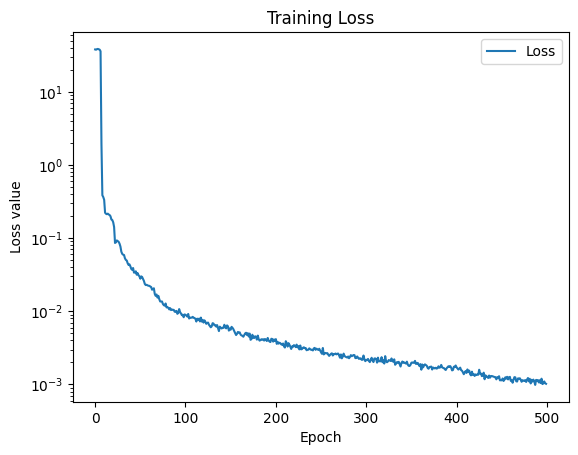

In [6]:
t0, tf, dt = 0.0, 20.0, 0.01
time = np.arange(t0, tf, dt)
trajectory = np.zeros((len(time), 2))
trajectory[0] = [0.5, 0.0]

dqdt, dpdt = derivatives_test(trajectory[0])

for i in range(1, len(time)):
    q_n, p_n = trajectory[i-1]
    v_n = dqdt
    a_n = dpdt / m_test

    q_new = q_n + v_n*dt + 0.5*a_n*dt**2

    dqdt_new, dpdt_new = derivatives_test([q_new, p_n])
    a_new = dpdt_new / m_test

    v_new = v_n + 0.5*(a_n + a_new)*dt
    p_new = v_new * m_test

    trajectory[i] = [q_new, p_new]
    dqdt, dpdt = v_new, dpdt_new
    
# compute analytic solution
b= 0
gamma = b/(2*m_test)
omega_d = np.sqrt(k_test/m_test - gamma**2)
q0 = trajectory[0][0]
q_analytic = q0 * np.exp(-gamma*time) * np.cos(omega_d * time)



# plot displacement
plt.figure()
plt.plot(time, trajectory[:,0], label='Numerical solution')
plt.plot(time, q_analytic, '--', label='Analytic solution')
plt.xlabel('t')
plt.ylabel('q(t)')
plt.legend()
plt.title(f'Test trajectory for m={m_test}, k={k_test}')
plt.show()

## plot difference at each time step
plt.figure()
plt.plot(time, trajectory[:,0] - q_analytic, label='Difference')
plt.xlabel('t')
plt.ylabel('Difference (q_numerical - q_analytic)')
plt.legend()
plt.title('Difference between numerical and analytic solution')
plt.show()


## plot loss
plt.figure()
plt.yscale('log')
plt.plot(loss_track, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.legend()
plt.title('Training Loss')
